# Evaluation Notebook for Rotated MNIST Experiments

F.X. Vialard and R. Kwitt and S. Wei and M. Niethammer    
**A Shooting Formulation of Deep Learning**    
*NeurIPS 2020*

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

sys.path.append('../../')
import neuro_shooting.shooting_blocks as shooting_blocks
import neuro_shooting.shooting_models as shooting_models
import neuro_shooting.generic_integrator as generic_integrator
import neuro_shooting.shooting_hooks as sh
import neuro_shooting.vector_visualization as vector_visualization
import neuro_shooting.validation_measures as validation_measures
import neuro_shooting.parameter_initialization as pi
import neuro_shooting.utils as utils

from autoencoder import ShootingAEMasked
from utils import load_data, Dataset
import scipy.stats as ss
import os

import pickle
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
sns.set_style("whitegrid")

Once we have trained the autoencoder model of [Yildiz et al., NeurIPS 19](https://papers.nips.cc/paper/2019/hash/99a401435dcb65c4008d3ad22c8cdad0-Abstract.html) with our
*UpDown* particle shooting model (and variants thereof, e.g., setting `--use_particle_rnn` during training) applied to the encoder output, we collect the results from multiple training runs (with random initializations) and store them in a Pandas dataframe.

In [2]:
import glob
import pandas as pd
from collections import defaultdict
dirs = glob.glob('rotated_mnist_runs/*')


df = pd.DataFrame(columns=['res_id',
                           'shooting_dim', 
                           'inflation_factor', 
                           'nr_of_particles',
                           'sim_weight',
                           'norm_weight',
                           'pw',
                           'use_particle_free_rnn_mode',
                           'use_particle_rnn_mode',
                           'avg_mse',
                           'std_mse',
                           ])


                           
for i,d in enumerate(dirs):
    with open(os.path.join(d, 'args.pkl'), 'rb') as fid:
        args = pickle.load(fid)
    with open(os.path.join(d, 'tracker.pkl'), 'rb') as fid:
        tracker = pickle.load(fid)
        
    df = df.append({
        'res_id': i,
        'shooting_dim':     args.shooting_dim, 
        'inflation_factor': args.inflation_factor , 
        'nr_of_particles':  args.nr_of_particles,
        'sim_weight':       args.sim_weight,
        'norm_weight':      args.norm_weight,
        'pw':               args.pw,
        'use_particle_free_rnn_mode': args.use_particle_free_rnn_mode,
        'use_particle_rnn_mode':      args.use_particle_rnn_mode,
        'avg_mse' : np.mean(tracker[-1]['img_eval_errors']),
        'std_mse' : np.std(tracker[-1]['img_eval_errors'])
        }, ignore_index=True)

In [3]:
df # print all results

,res_id,shooting_dim,inflation_factor,nr_of_particles,sim_weight,norm_weight,pw,use_particle_free_rnn_mode,use_particle_rnn_mode,avg_mse,std_mse
0,0,20,10,100,1.0,0.05,1.0,True,False,0.013762,0.007012
1,1,20,10,100,1.0,0.05,1.0,False,False,0.011205,0.006349
2,2,20,10,100,1.0,0.05,1.0,False,False,0.010941,0.006355
3,3,20,10,100,1.0,0.05,1.0,False,False,0.011287,0.006702
4,4,20,10,100,1.0,0.05,1.0,True,False,0.011470,0.006007
5,5,20,10,100,1.0,0.05,1.0,False,False,0.010979,0.006490
6,6,20,10,100,1.0,0.05,1.0,False,False,0.011468,0.006510
7,7,20,10,100,1.0,0.05,1.0,True,False,0.014019,0.007090
8,8,20,10,100,1.0,0.05,1.0,True,False,0.012693,0.006747
9,9,20,10,100,1.0,0.05,1.0,True,False,0.011228,0.006596


In [4]:
def plot_loss_curves(dirs, res_id):
    with open(os.path.join(dirs[res_id], 'tracker.pkl'),'rb') as fid:
        tracker = pickle.load(fid)
    
    plt.figure(figsize=(10,3))
    plt.plot([tracker[i]['it_sim_loss'] for i in range(1,300)], label='Training loss')
    plt.plot([tracker[i]['all_eval_error'] for i in range(1,300)], label='Testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('res_id = {}'.format(res_id))
    plt.legend()    

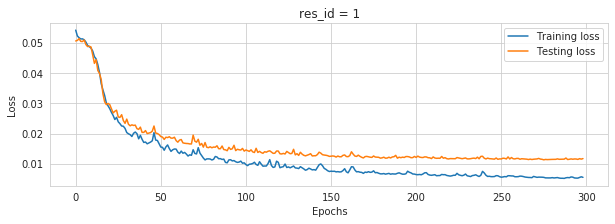

In [5]:
plot_loss_curves(dirs, 1)

## Performance comparison

Next, we extract the results for our particle shooting *UpDown* model (**dyn. w. particles**) and the particle-free *UpDown* model (**static direct**). **Note** that the results here differ slightly from Fig. 4 of the paper, due to a complete re-run of the experiments.

In [6]:
print('dyn. w particles | MSE={:.4f}'.format(
    df.query('inflation_factor == 10 and \
          norm_weight == 0.05 and \
          use_particle_rnn_mode == False and \
          use_particle_free_rnn_mode == False')['avg_mse'].mean()))

print('static direct    | MSE={:.4f}'.format(
    df.query('inflation_factor == 10 and \
          norm_weight == 0.05 and \
          use_particle_rnn_mode == False and \
          use_particle_free_rnn_mode == True')['avg_mse'].mean()))

dyn. w particles | MSE=0.0112
static direct    | MSE=0.0126


## Visualizations

We run the **first** image of each sequence in the testing data through the encoder, integrate forward in time (for 15 timepoints) and decode the results. This means, after running the *UpDown* model(s) forward in time, we get 16 representations in $\mathbb{R}^d$ ($d=20$ as in the paper) that are decoded. We store these representations for visualization. 

In [7]:
def extract_representations(dirs, res_id):
    Xtr, Xtest, N, T = load_data()
    testset = data.DataLoader(
        Dataset(Xtest), 
        batch_size=25, 
        shuffle=False)
    
    model = torch.load(os.path.join(dirs[res_id], 'model.pt'))
    device = next(model.parameters()).device
    model.eval()
    
    Zs = []
    for inp in testset:
        inp = inp.to(device)    
        Z,_,_ = model(inp[:,0,...], use_mask=False)
        Zs.append(Z.detach().cpu())
    X = torch.cat(Zs, dim=0).numpy()
    return X

### PCA plots

As a first visualization (see paper), we take, for one image, the 16 20-dimensional representations for each of the 16 timepoints and project them onto the 2 largest principal components. We do this for a selection of 100 testing images and plot the results in 2D. 

In [8]:
def plot_pca(X, title_str):
    color = cm.rainbow(np.linspace(0,1,16))
    N, T, D = X.shape
    
    plt.figure(figsize=(6,3))
    for i in np.random.randint(0,N,100):
        pca = PCA(n_components=2)
        B = pca.fit_transform(X[i,:,:])
        for j in range(16):
            plt.plot(B[j,0],B[j,1], '.', markersize=10, color=color[j], alpha=1.0)
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    plt.title(title_str)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

**Dyn. w particles UpDown model**

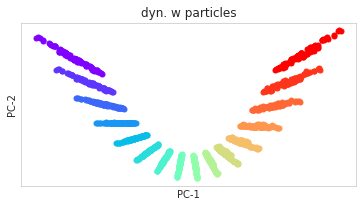

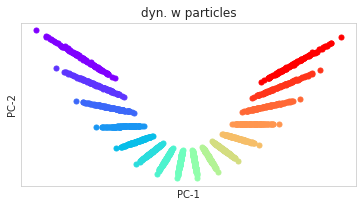

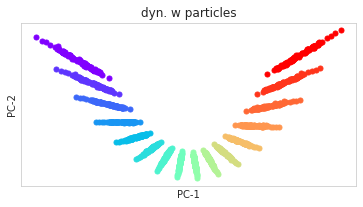

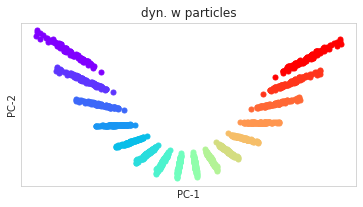

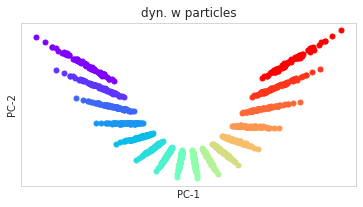

In [9]:
dyn_w_particles_idx = list(
    df.query('inflation_factor == 10 and \
          norm_weight == 0.05 and \
          use_particle_rnn_mode == False and \
          use_particle_free_rnn_mode == False')['res_id'])
for i in dyn_w_particles_idx:
    plot_pca(extract_representations(dirs, i),  'dyn. w particles')

**Static direct UpDown model**

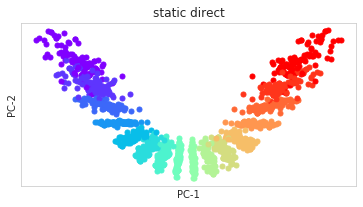

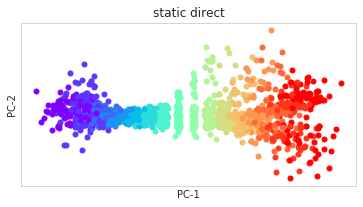

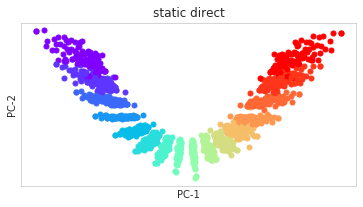

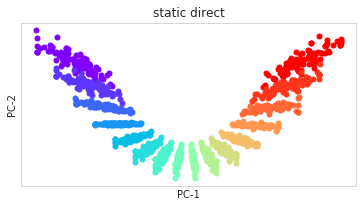

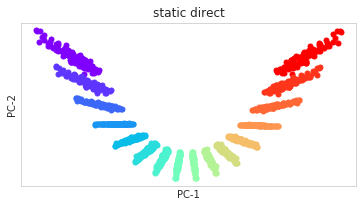

In [10]:
static_direct_idx = list(
    df.query('inflation_factor == 10 and \
          norm_weight == 0.05 and \
          use_particle_rnn_mode == False and \
          use_particle_free_rnn_mode == True')['res_id'])
for i in static_direct_idx:
    plot_pca(extract_representations(dirs, i),  'static direct')

### TSNE plots

For the 542 testing images, we get (in total) $542 \cdot 16$ representations (as we have 16 time points). Out of those, we randomly select $5,000$ and compute a TSNE into 2D. The points are colored by angle.

In [13]:
def plot_tsne(X, title_str, N_random=5000):
    color = cm.rainbow(np.linspace(0,1,16))
    N, T, D = X.shape
    all_representations = X.reshape(N*T,D)
    ix = np.random.randint(0,N*T,N_random)
    ll = np.array(list(range(1,T+1))*N).reshape(-1)
    all_representations_embedded = TSNE(n_components=2).fit_transform(all_representations[ix,:])  
    
    plt.figure()
    for angle_i in range(1,T+1):
        angle_i_idx = np.where(ll[ix]==angle_i)[0]
        plt.plot(
            all_representations_embedded[angle_i_idx,0],
            all_representations_embedded[angle_i_idx,1], 
            '.',
            color=color[angle_i-1], 
            label='{}'.format(angle_i), 
            markersize=5, 
            alpha=1.0)
    plt.title(title_str)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

**Dyn. w. particles UpDown model**

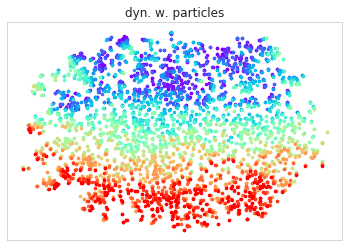

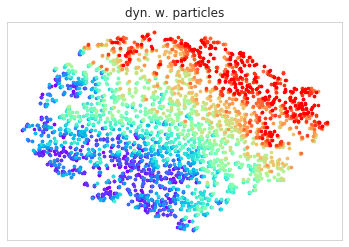

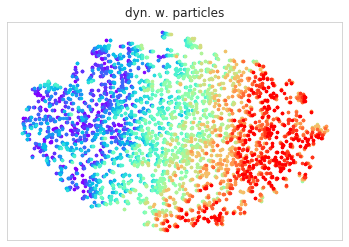

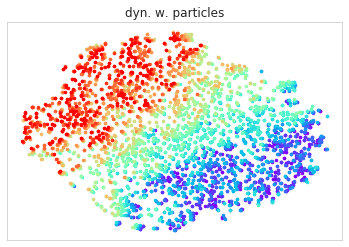

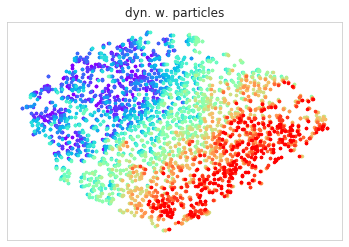

In [14]:
dyn_w_particles_idx = list(
    df.query('inflation_factor == 10 and \
          norm_weight == 0.05 and \
          use_particle_rnn_mode == False and \
          use_particle_free_rnn_mode == False')['res_id'])
for i in dyn_w_particles_idx:
    plot_tsne(extract_representations(dirs, i), 'dyn. w. particles')

**Static direct UpDown model**

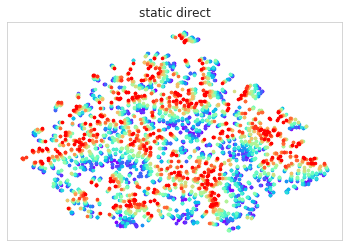

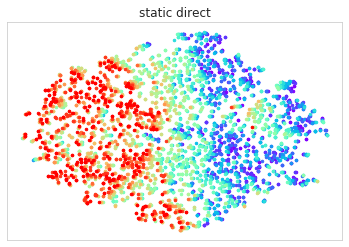

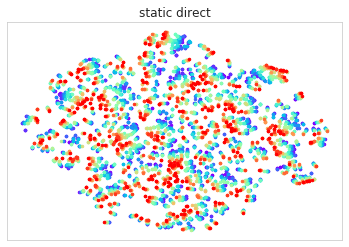

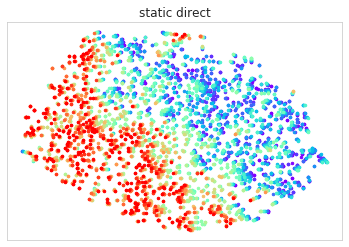

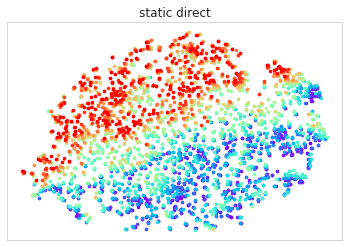

In [15]:
static_direct_idx = list(
    df.query('inflation_factor == 10 and \
          norm_weight == 0.05 and \
          use_particle_rnn_mode == False and \
          use_particle_free_rnn_mode == True')['res_id'])
for i in static_direct_idx:
    plot_tsne(extract_representations(dirs, i),  'static direct')

### Reconstruction plots

Finally, we create some reconstruction plots for the full sequence of 16 angles and compare them to the actual testing sequences. Remember that the reconstructions are obtained by just inputting the **first** image of each sequence to the autoencoder.

In [16]:
def plot_reconstructions(npbatch, indices, where, prefix):
    for idx in indices:
        img_list = [torch.tensor(npbatch[idx,i,:,:]).unsqueeze(0) for i in range(16)]
        imgsave(
            make_grid(img_list, padding=2, nrow=16, normalize=True, pad_value=1), 
            where,
            '{}{}.pdf'.format(prefix, idx))
    

def imgsave(img, where, fname):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(20,4))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.savefig(os.path.join(where, fname), bbox_inches='tight', pad_inches=0)

In [17]:
with open(os.path.join(dirs[2], 'images.pkl'), 'rb') as fid:
     images = pickle.load(fid)
batch_idx = 0
img_indices = [10,15,18,1]

Selection of actual testing sequences ...


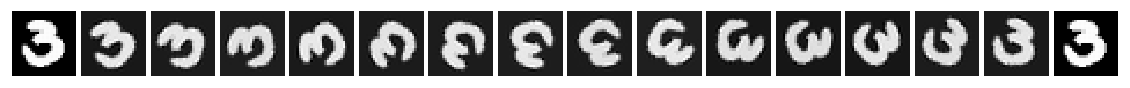

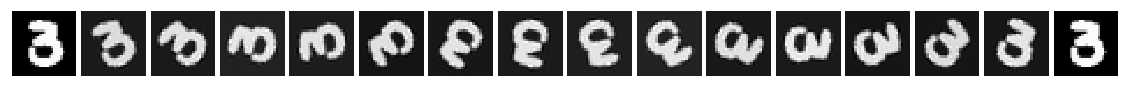

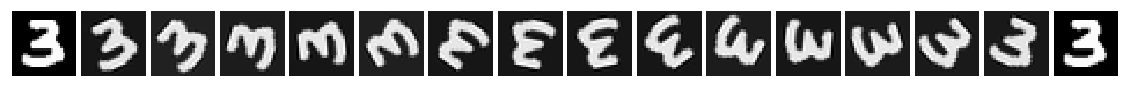

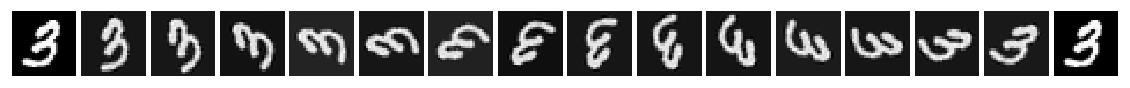

In [20]:
print('Selection of actual testing sequences ...')
plot_reconstructions(images['Vs'][batch_idx],
                     img_indices,
                     dirs[2],
                     'true_batch_{}_'.format(batch_idx))

... and the corresponding reconstructions


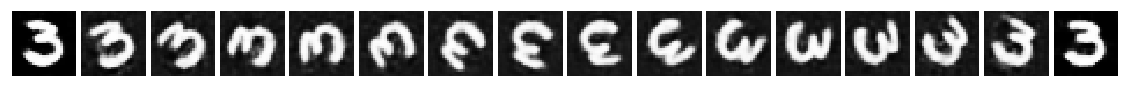

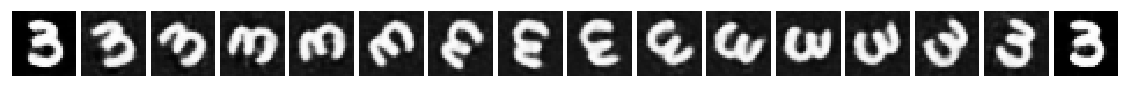

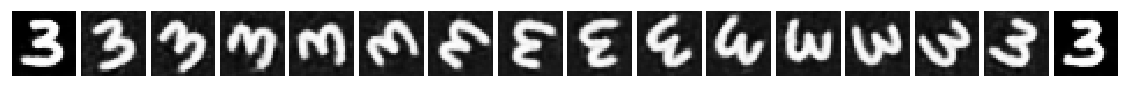

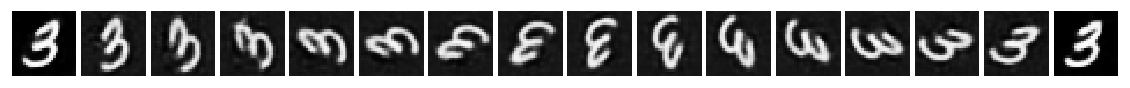

In [21]:
print('... and the corresponding reconstructions')
plot_reconstructions(images['Rs'][batch_idx],
                     img_indices,
                     dirs[2],
                     'pred_batch_{}_'.format(batch_idx))

## Animation Fun

In [29]:
import glob
from PIL import Image
from matplotlib import cm

img, *imgs = [Image.fromarray(np.uint8(cm.gray(images['Rs'][0][12,i,:,:])*255)) for i in range(16)]
img.save(
    fp='rotated_mnist_animation_fun.gif', 
    format='GIF', 
    append_images=imgs, 
    save_all=True, 
    duration=200, 
    loop=0)

In [30]:
from IPython.display import Image
Image('rotated_mnist_animation_fun.gif',width=200) 